Author: Daniel Alvarez

<alvarez.da@gmail.com>

### Prompt

You have been provided with a (synthetic) dataset of transactions that are potentially fraudulent. Whether or not a transaction is fraudulent is indicated by the column `y`. A `0` indicates a legitimate transaction, whereas a `1` indicates that it was fraudulent. Each transaction has a 4-dimensional feature vector associated with it.

Your task is to design, implement, and evaluate a classifier to predict if a given transaction is fraudulent and evaluate your model's performance. Treat this as you would a business problem: explore the data, ask lots of questions and discuss your design decisions.

### Installations

In [1]:
!pip install xgboost

     |████████████████████████████████| 1.2 MB 3.2 MB/s eta 0:00:01


In [2]:
!pip install lightgbm

     |████████████████████████████████| 1.2 MB 3.6 MB/s eta 0:00:01     |████▉                           | 184 kB 3.6 MB/s eta 0:00:01


In [29]:
!pip install boruta

     |████████████████████████████████| 56 kB 1.8 MB/s eta 0:00:011


In [1]:
## Import packages.

# General libraries.
import os, platform, sys
import random
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce
#from pandas.plotting import autocorrelation_plot

#Standardize variables
from sklearn.preprocessing import StandardScaler

# Import joblib for data persistance
import joblib

# import parquet for persistence
import pyarrow.parquet as pq

# SK-learn libraries for learning
from sklearn.model_selection import train_test_split

# sklearn libraries
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectKBest
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.ensemble import GradientBoostingClassifier as GBC

from sklearn.ensemble import AdaBoostClassifier as ABC
from sklearn.neural_network import MLPClassifier

#import lightgbm
#from lightgbm import LGBMClassifier
#import xgboost as xgb
#from xgboost.sklearn import XGBClassifier
from sklearn.impute import SimpleImputer, KNNImputer
#from sklearn.impute import IterativeImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, average_precision_score, confusion_matrix, plot_confusion_matrix, classification_report, roc_curve, auc, f1_score, make_scorer, recall_score, roc_auc_score
from sklearn.decomposition import PCA

from scipy.stats import randint, uniform
from scipy.interpolate import interp1d

# apply Boruta method for dimensionality reduction
from boruta import BorutaPy

# Set display of images in the notebook
%matplotlib notebook

In [2]:
# check versions
print(os.name)
print(f'Platform system: {platform.system()}. Release version: {platform.release()}')
print(sys.version)

print(f'Numpy version: {np.__version__}')
print(f'Pandas version: {pd.__version__}')
print(f'Seaborn version: {sns.__version__}')
print(f'Joblib version: {joblib.__version__}')

posix
Platform system: Darwin. Release version: 18.6.0
3.6.10 |Anaconda, Inc.| (default, Mar 23 2020, 17:45:12) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
Numpy version: 1.14.2
Pandas version: 0.25.3
Seaborn version: 0.10.0
Joblib version: 0.14.1


In [3]:
# Set random seed for this project
random_seed = 224
random.seed(random_seed)

### Ingestion

In [4]:
# Read data from csv and set data types (dtype), except the first column -'calldate'- which will be parsed later.
df = pd.read_csv("./data/raw_data.csv", sep=',', engine='python')

In [5]:
# Convert columns to str without spaces in lower case
df.columns = df.columns.str.replace('\s+', '_').str.lower()

### Exploratory Data Analysis

In [6]:
# Inspect the dataframe
print(df.shape)
print(df.info())

(1000, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
x0    951 non-null float64
x1    963 non-null float64
x2    956 non-null float64
x3    957 non-null float64
y     1000 non-null int64
dtypes: float64(4), int64(1)
memory usage: 39.2 KB
None


In [7]:
# first 5 rows
df.head(5)

,x0,x1,x2,x3,y
0,-331.070808,-9.502577,1150.546337,41.414802,0
1,8.373484,118.055035,3285.208972,-208.646805,0
2,-331.069064,-13.001692,-170.948896,-48.085035,0
3,-322.432286,2.513188,1344.314314,31.998978,0
4,NaN,-17.557358,672.131651,20.300037,0


In [8]:
# last 5 rows
df.tail(5)

,x0,x1,x2,x3,y
995,-311.840895,111.876707,202.093138,-219.195165,1
996,-388.530067,94.083265,-860.069680,-220.657262,1
997,33.385342,109.091292,3066.218437,-226.723099,0
998,-334.522158,NaN,1152.983543,49.055115,0
999,50.136108,123.797677,3221.977269,-247.962631,0


Data quality checks

In [9]:
### analyze null values
def nullvalues(d):
    ''' Number of null values for each feature and percentage of null values for each feature'''
    print("{:60s}|{:18s}|{:10s}".format("Feature","Null values","Null Values as a Percent of Total"))
    print("="*100)
    for col in d.columns:
        null_values = d[col].isnull().sum(axis=0)
        null_values_pct = d[col].isnull().sum(axis=0)/len(d)*100
        print("{:60s}|{:14d}\t|{:6f}".format(str(col),null_values,null_values_pct))

In [10]:
nullvalues(d=df)

Feature                                                     |Null values       |Null Values as a Percent of Total
x0                                                          |            49	|4.900000
x1                                                          |            37	|3.700000
x2                                                          |            44	|4.400000
x3                                                          |            43	|4.300000
y                                                           |             0	|0.000000


In [11]:
### analyze cardinality
def cardinality(data):
    ''' Check number of unique values of variables not accounting for null values '''
    print("{:35s}\t| {:10s}\t| {:10s}".format("Feature","Distinct Values","Distinct Values as a Percent of Total"))
    print("="*100)
    for col in data.columns[:]:
        unique_values = len(np.unique(data[col].ffill()))
        unique_values_pct = len(np.unique(data[col].ffill()))/len(data) 
        print("{:35s}\t| {:10d}\t\t| {:6f}".format(str(col),unique_values,unique_values_pct))

In [12]:
cardinality(data=df)

Feature                            	| Distinct Values	| Distinct Values as a Percent of Total
x0                                 	|        951		| 0.951000
x1                                 	|        963		| 0.963000
x2                                 	|        956		| 0.956000
x3                                 	|        957		| 0.957000
y                                  	|          2		| 0.002000


In [13]:
### analyze duplicates
def rowduplication(data):
    ''' Assess the number and percent of duplicates for entire rows in dataset '''
    data_dedup = data.drop_duplicates(keep='first')
    data_duplicates = data[data.duplicated(subset=None, keep='first')]
    
    print('Shape of de-duplicated dataset', data_dedup.shape)
    print('Number of duplicates:', len(data) - len(data_dedup))
    print('Confirm number of duplicates:', len(data_duplicates)) 

In [14]:
rowduplication(data=df)

Shape of de-duplicated dataset (1000, 5)
Number of duplicates: 0
Confirm number of duplicates: 0


In [15]:
def duplicationanalyzer(data):
    ''' Assess the number and percentage of duplicates for each variable in the dataset'''
    variable = pd.Series(np.nan)
    
    for var in data:
        ''' Output the number of duplicates and percentage of duplicates '''
        variable = data[var]
        
        # construct variable dataframe less duplicates
        variable_dedup = variable.drop_duplicates(keep='first')
        
        #print the number of duplicates
        duplicates=data[data[var].duplicated(keep=False)]
        print(var)
        print('Number of duplicates: ', len(duplicates))
        
        #print the percentage of duplicates
        percentage = "{0:.2f}".format(len(duplicates)/len(data))
        print('Percentage of duplicates: ', percentage)

In [16]:
duplicationanalyzer(data=df)

x0
Number of duplicates:  49
Percentage of duplicates:  0.05
x1
Number of duplicates:  37
Percentage of duplicates:  0.04
x2
Number of duplicates:  44
Percentage of duplicates:  0.04
x3
Number of duplicates:  43
Percentage of duplicates:  0.04
y
Number of duplicates:  1000
Percentage of duplicates:  1.00


In [69]:
# define functions for summary statistics on categorical and numeric variables

def catvardistribution(data, var, title):
    ''' Examine value counts and countplots'''
    fig, axs = plt.subplots(1, 1, sharey=True, tight_layout=True)
    print(data[var].value_counts(dropna=False))
    sns.set(style='darkgrid')
    ax = sns.countplot(x=data[var], data=data)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.set_title(title)
    plt.show()

def summarystats(data, var, titleplot, n_bins):
    ''' Print summary statistics, show histogram and boxplot '''
    print(data[var].unique())
    print(data[var].describe())
    n_bins = n_bins
    fig, axs = plt.subplots(1, 1, sharey=True, tight_layout=True)
    plt.hist(data[var], bins=n_bins)
    plt.title(titleplot, loc='center', pad=None)
    plt.show()
#     sns.set(style='darkgrid')
#     ax = sns.boxplot(x=data[var])
#     print(ax)

def sidebysideboxplots(data, xvar, yvar, xtitle, ytitle):
    ''' Generate side-by-side boxplots'''
    ax = sns.boxplot(x=xvar, y=yvar, data=data)
    ax.set_xlabel(xtitle)
    ax.set_ylabel(ytitle)

def corrmap(data,figx, figy):
    '''Generate correlation heatmap'''
    var_corr = data.corr()
    var_corr = var_corr.round(3)
    # plot the heatmap and annotation on it
    fig, ax = plt.subplots(figsize=(figx,figy))         # Sample figsize
    sns.heatmap(var_corr, xticklabels=var_corr.columns, yticklabels=var_corr.columns, annot=True)

    # Fix axes
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show()
    
def binary_means(data, feature_group, y_col):
    ''' Show mean scores by feature category '''
    cols = feature_dict[feature_group]
    #cols = feat_eng
    for col in cols:
        print(col)
        print(df.groupby(y_col)[col].mean())
        print('')

In [17]:
# create list of string variables
# string_vars = list()
# for x in df.columns:
#     if df[x].dtypes == 'object':
#         string_vars.append(x) 

# string_vars.remove('') # remove outcome variable

# create list of float variables
float_vars = list()        
for x in df.columns:
    if df[x].dtypes == 'float64':
        float_vars.append(x)
        
# print(string_vars) 
print(float_vars)

# save dictionary of feature lists
#feature_dict = {'strings':string_vars, 'floats':float_vars}
feature_dict = {'floats':float_vars}

['x0', 'x1', 'x2', 'x3']


<IPython.core.display.Javascript object>


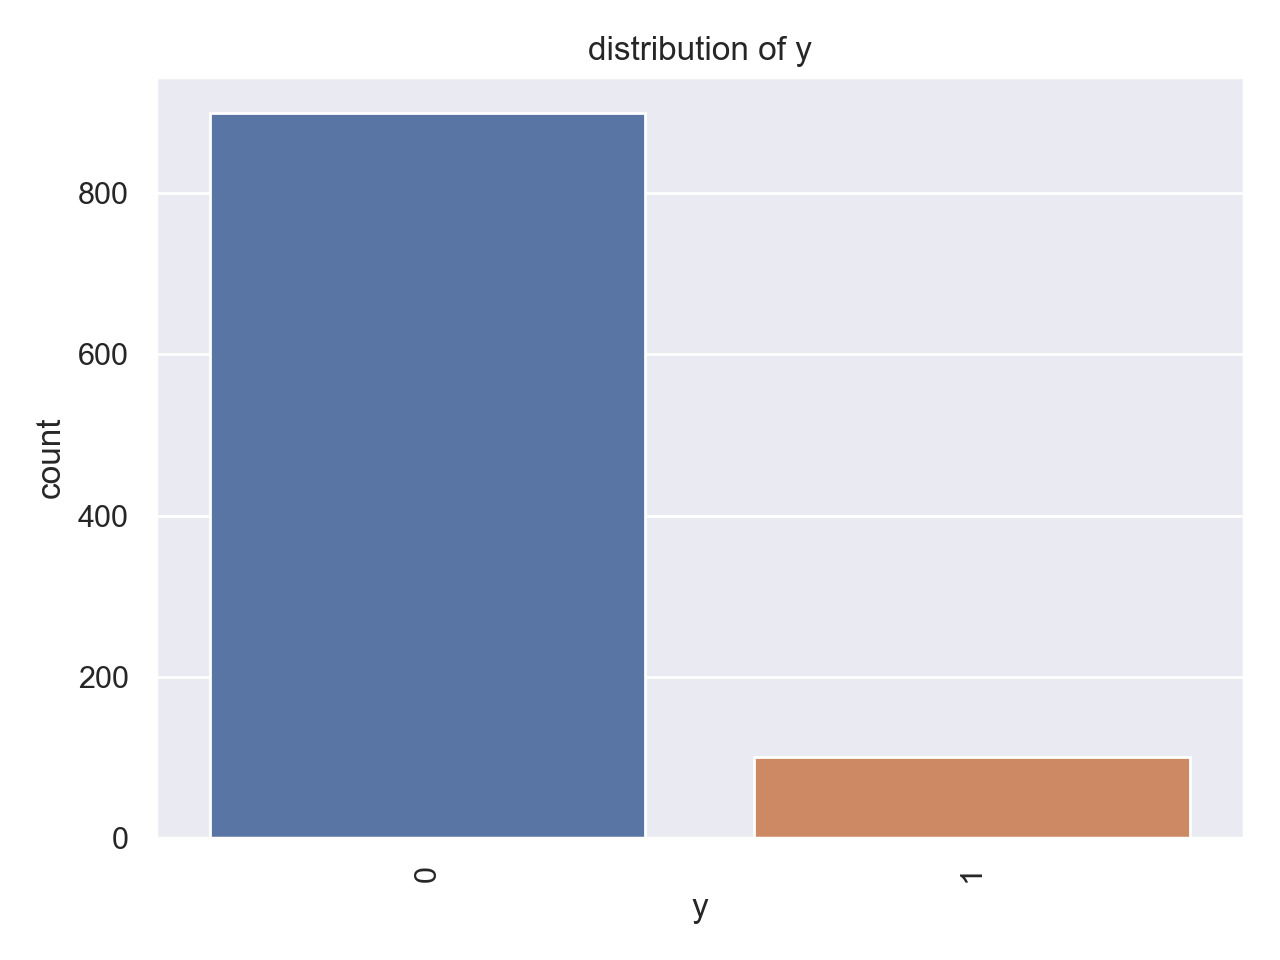

0    899
1    101
Name: y, dtype: int64


In [70]:
catvardistribution(data=df, var='y', title='distribution of y')

[-3.31070808e+02  8.37348443e+00 -3.31069064e+02 -3.22432286e+02
             nan -3.22013594e+02 -3.26454079e+02 -3.28903444e+02
  5.86614884e+01 -3.31805399e+02 -3.24979835e+02 -3.27478160e+02
 -3.29318921e+02  7.13150571e+01  7.92053069e+00 -3.40091888e+02
  4.11089951e+01 -3.29726829e+02 -3.28519982e+02 -3.39930818e+02
  1.48723046e+01 -3.32471138e+02 -3.27879011e+02 -3.30784976e+02
  3.63852923e+01 -3.74470001e+02 -3.34129367e+02  1.71356308e+01
  3.31666659e+01 -3.18326095e+02  2.17209990e+01 -2.32575583e+01
  7.42906591e+01 -3.30746954e+02 -3.15738473e+02  5.15541652e+01
  4.96019722e+01 -3.26002529e+02  3.93390900e+01  1.21861850e+01
 -3.29281797e+02  4.15051833e+01 -3.31178318e+02 -3.22488882e+02
  4.77612222e+01 -3.39307843e+02  1.59326404e+01 -2.50531095e+01
  2.87977864e+01  5.33755879e+01 -3.20894356e+02 -3.37832110e+02
 -3.52325042e+01 -3.58413149e+02  3.78900077e+01  4.90998188e+01
 -3.34025144e+02  2.81773786e+01  6.26002959e+01 -3.35871586e+02
 -3.23500187e+02  3.66772

<IPython.core.display.Javascript object>


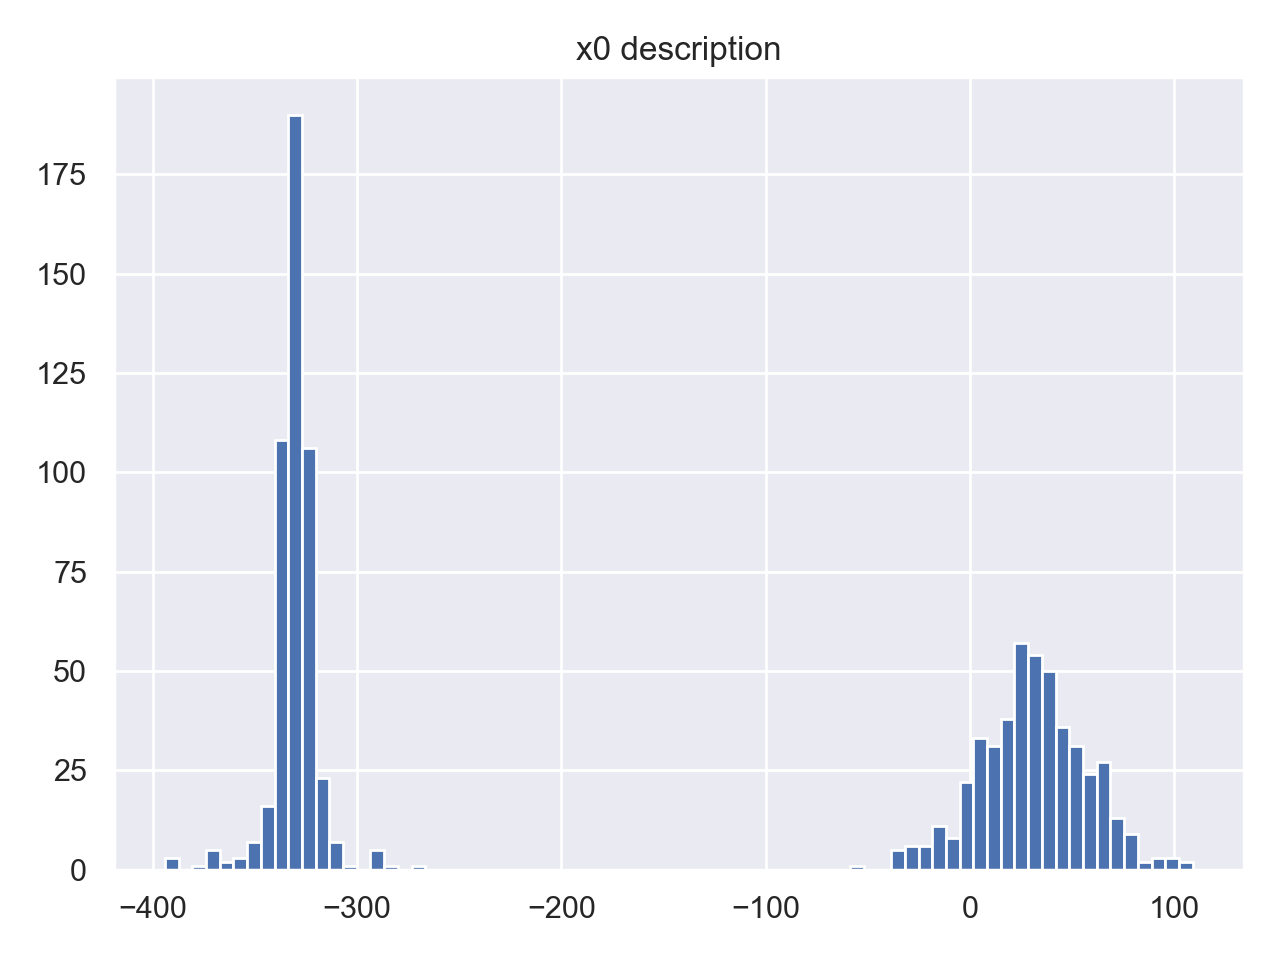

/anaconda/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:780: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/anaconda/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:781: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


In [71]:
summarystats(data=df, var='x0', titleplot='x0 description', n_bins=75)

[-9.50257728e+00  1.18055035e+02 -1.30016919e+01  2.51318841e+00
 -1.75573577e+01  8.10477352e+00             nan -7.42568791e+00
  1.02909889e+02 -1.32179426e+01  2.81174552e-01 -3.21448442e+00
 -8.48044455e+00  1.19369474e+02  1.03971438e+02 -2.57137945e+01
  1.12443960e+02 -9.61709939e+00 -5.19091753e+00 -2.97317556e+01
 -1.51195556e+01 -1.41197573e+01 -7.09071164e+00 -1.37562483e+01
 -9.47816979e+00  1.10000057e+02 -1.58090680e+01  1.16411479e+02
  1.05486308e+02  7.85849092e+00  1.15019248e+02  1.11644473e+02
  1.01909361e+02 -1.06754511e+01  1.43670217e+01  1.17275484e+02
  1.14165788e+02 -4.02710878e-01  1.09345334e+02  1.07932708e+02
  1.18770437e+02 -8.76819268e+00  9.32998464e+01 -1.38802715e+01
 -7.78245699e-01  1.25224886e+02 -2.62956336e+01  1.21704647e+02
  1.18310464e+02  1.11311886e+02  1.02814602e+02 -2.14310852e+01
  9.27987159e+01  1.02316377e+02  1.10491312e+02  1.24110005e+02
 -1.73795992e+01  9.65074580e+01 -6.58593498e+00 -1.97431597e+01
  7.35628715e-02  1.08466

<IPython.core.display.Javascript object>


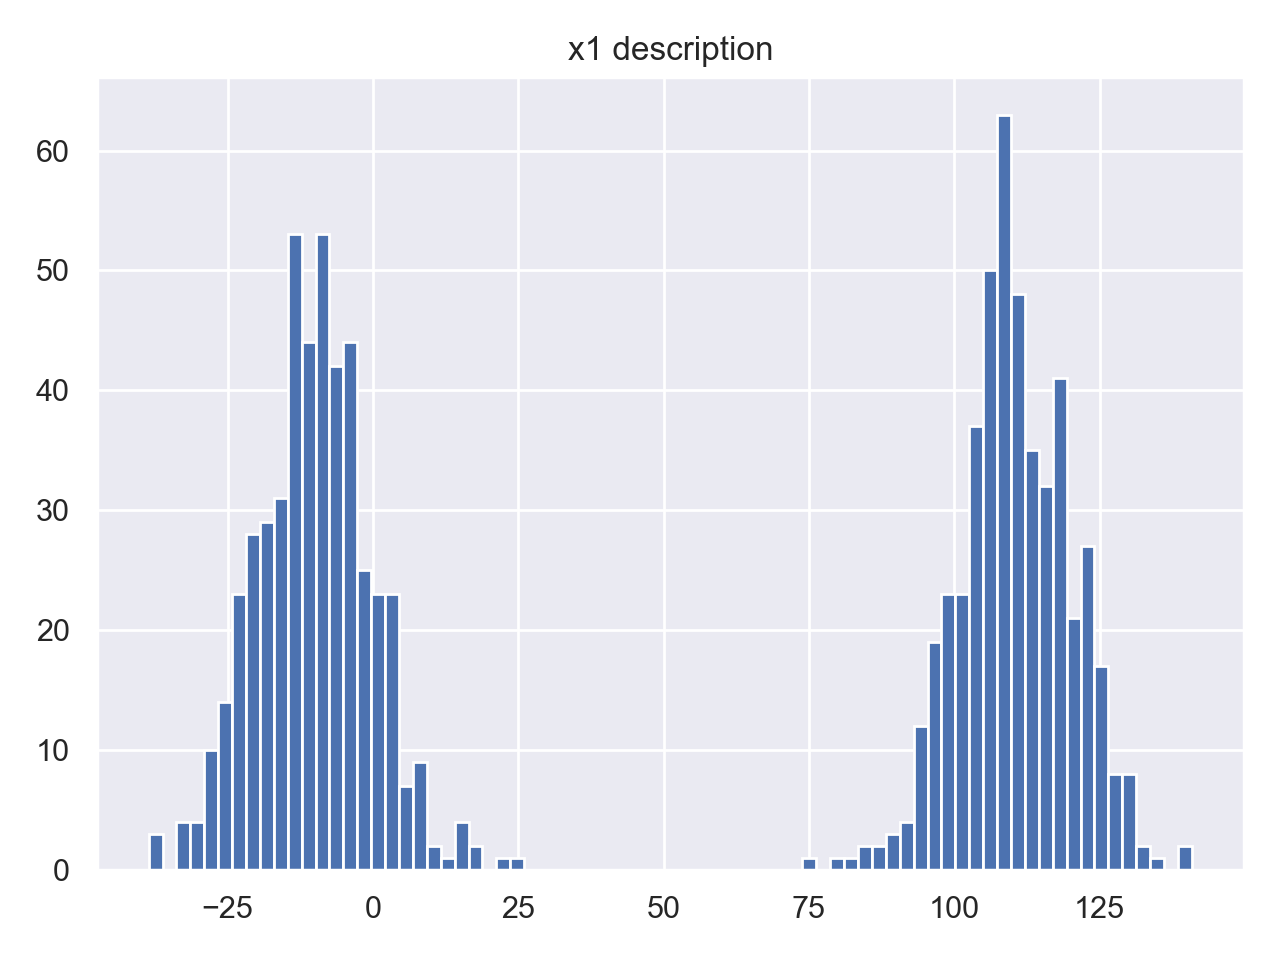

In [25]:
summarystats(data=df, var='x1', titleplot='x1 description', n_bins=75)

[ 1.15054634e+03  3.28520897e+03 -1.70948896e+02  1.34431431e+03
  6.72131651e+02  1.50925740e+03  4.80904281e+02  9.27184617e+02
  3.25659115e+03             nan  1.15511739e+03  1.51626780e+03
  5.02391225e+02  3.78313678e+03  2.95054832e+03  6.93061713e+02
  3.47773606e+03  1.00447096e+03  1.47750799e+03 -1.67355715e+02
  3.08927058e+02  6.93863291e+02  6.94936835e+02  6.11998265e+02
 -2.81110725e+02  6.72234493e+02  3.36159422e+03  3.21528693e+03
  8.21409945e+02  3.46627151e+03  3.01036442e+03  2.84790565e+03
  1.20167070e+03  1.23345082e+03  3.24018720e+03  3.09507215e+03
  7.93406097e+02  3.24452669e+03  3.14518404e+03  3.51243467e+03
  8.30541439e+02  3.14286426e+03  5.02228057e+02  7.58816501e+02
  3.30950066e+03  2.24962635e+02  3.24510833e+03  2.86522716e+03
  3.08776025e+03  3.08673155e+03  1.25296298e+03  9.72840436e+02
  2.32977451e+03 -3.29424996e+02  2.99568112e+03  3.59778150e+03
  6.95217004e+02  2.97118319e+03  8.22776668e+02  1.42621627e+03
  3.42359426e+03  1.33723

<IPython.core.display.Javascript object>


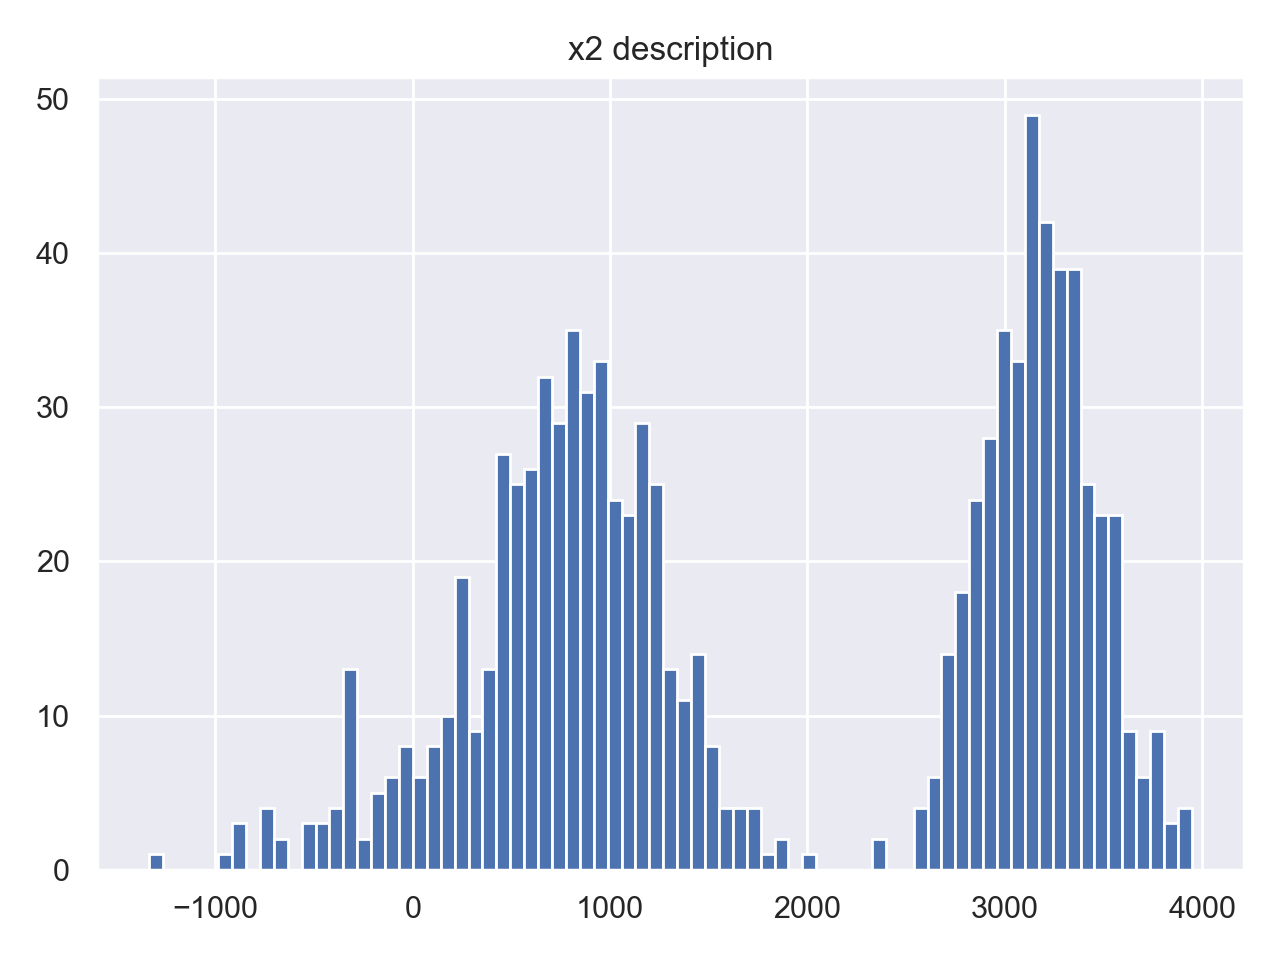

In [26]:
summarystats(data=df, var='x2', titleplot='x2 description', n_bins=75)

[ 4.14148024e+01 -2.08646805e+02 -4.80850350e+01  3.19989783e+01
  2.03000375e+01  3.52386846e+01 -1.27692982e+01  2.09564353e+01
             nan  3.89839641e+01  2.33613327e+01  5.60126472e+01
 -7.65595426e+00 -2.14468498e+02 -2.11395436e+02  3.84128876e+01
 -2.07072509e+02  3.02722896e+01  5.68296218e+01 -1.73725159e+01
 -2.27920511e+02  1.64351586e+01  3.17059467e+00  8.96812093e+00
 -2.11498815e+02 -2.11678323e+02  1.84400320e+01 -2.06233650e+02
 -2.10540268e+02 -1.60060315e+01 -1.99542306e+02 -1.98931646e+02
 -2.57388158e+02  4.66197853e+01  2.21486144e+00 -2.37846659e+02
 -2.42393725e+02 -9.00467614e-01 -2.18063787e+02 -2.06019951e+02
 -1.95717346e+02  1.62653572e+01 -2.02842116e+02  1.53318382e+00
 -5.02851367e+00 -2.42321090e+02  5.23981726e+00 -2.21699401e+02
 -2.18120459e+02 -2.25599910e+02 -2.28477290e+02  1.76936591e+01
  5.06723310e+01 -2.12147133e+02 -2.13800427e+02 -2.36691233e+02
 -2.20844382e+02  2.23577928e+01 -2.11542282e+02 -1.58831650e+02
  3.61753681e+01  4.21684

<IPython.core.display.Javascript object>


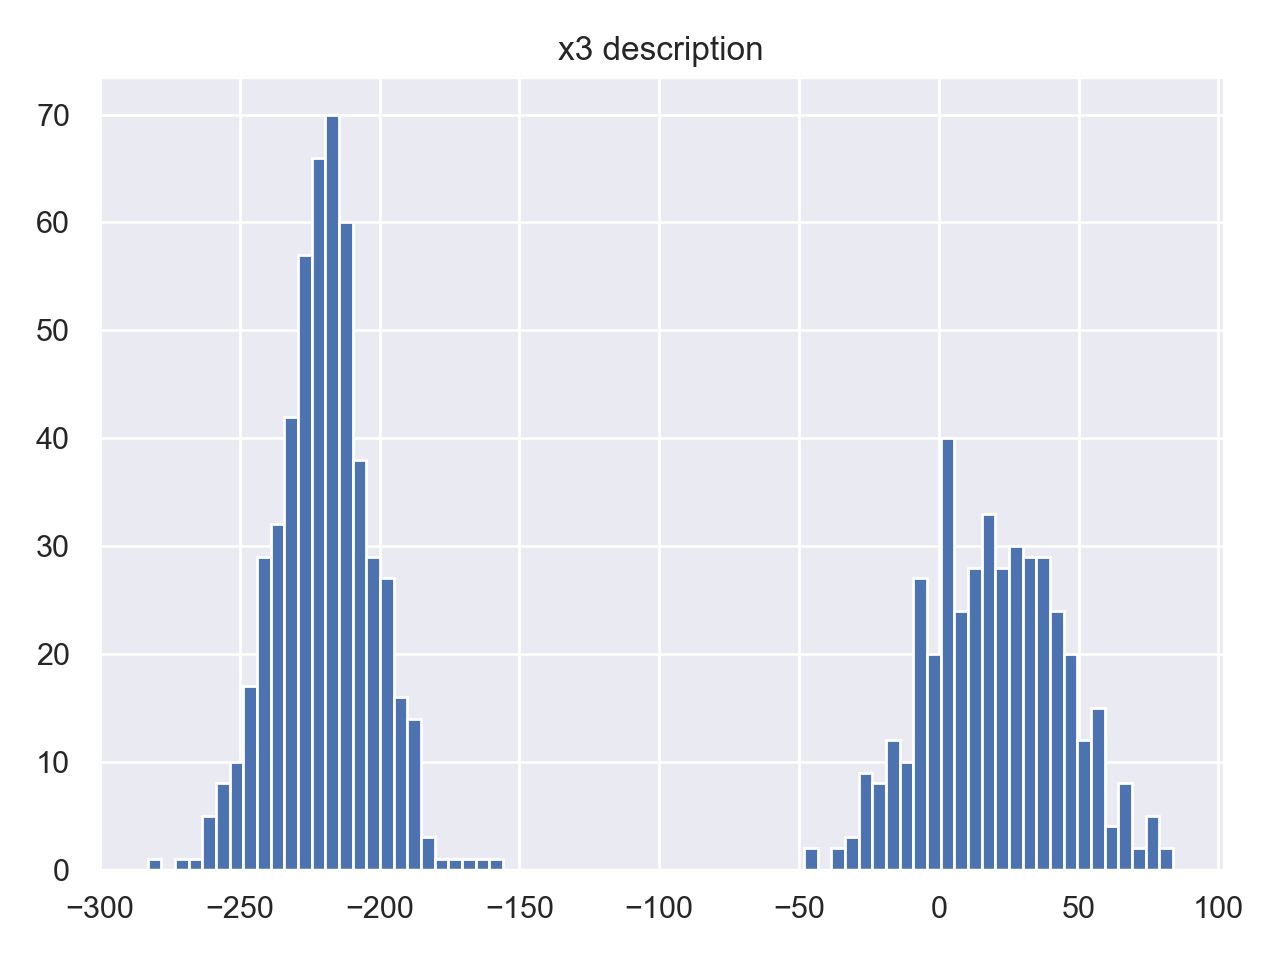

In [27]:
summarystats(data=df, var='x3', titleplot='x3 description', n_bins=75)

[  41.41480235 -208.6468052   -48.08503497   31.99897827   20.30003746
   35.23868461  -12.76929819   20.95643532           nan   38.98396414
   23.36133269   56.0126472    -7.65595426 -214.4684977  -211.39543567
   38.41288765 -207.07250908   30.27228961   56.82962177  -17.3725159
   16.43515862    3.17059467    8.96812093   18.44003198 -206.23365011
 -210.54026771  -16.00603154 -199.54230563 -198.93164646 -257.3881577
   46.61978534    2.21486144 -237.84665893 -242.39372467   -0.90046761
 -218.06378734 -206.0199514  -195.71734603   16.26535725 -202.84211565
    1.53318382   -5.02851367 -242.32109044    5.23981726 -221.69940129
 -218.12045868 -225.59991024 -228.47729004   17.69365912   50.67233099
 -212.14713254 -236.69123317 -220.84438246   22.35779278 -211.54228174
   36.1753681    42.16847895 -202.25155213   37.43979936   58.13836262
 -216.03833856 -235.03811274   83.70628163 -193.14736509 -212.41072711
 -242.73846158 -198.08016959    3.83422279 -196.7658943  -225.66982605
   -4.96

<IPython.core.display.Javascript object>


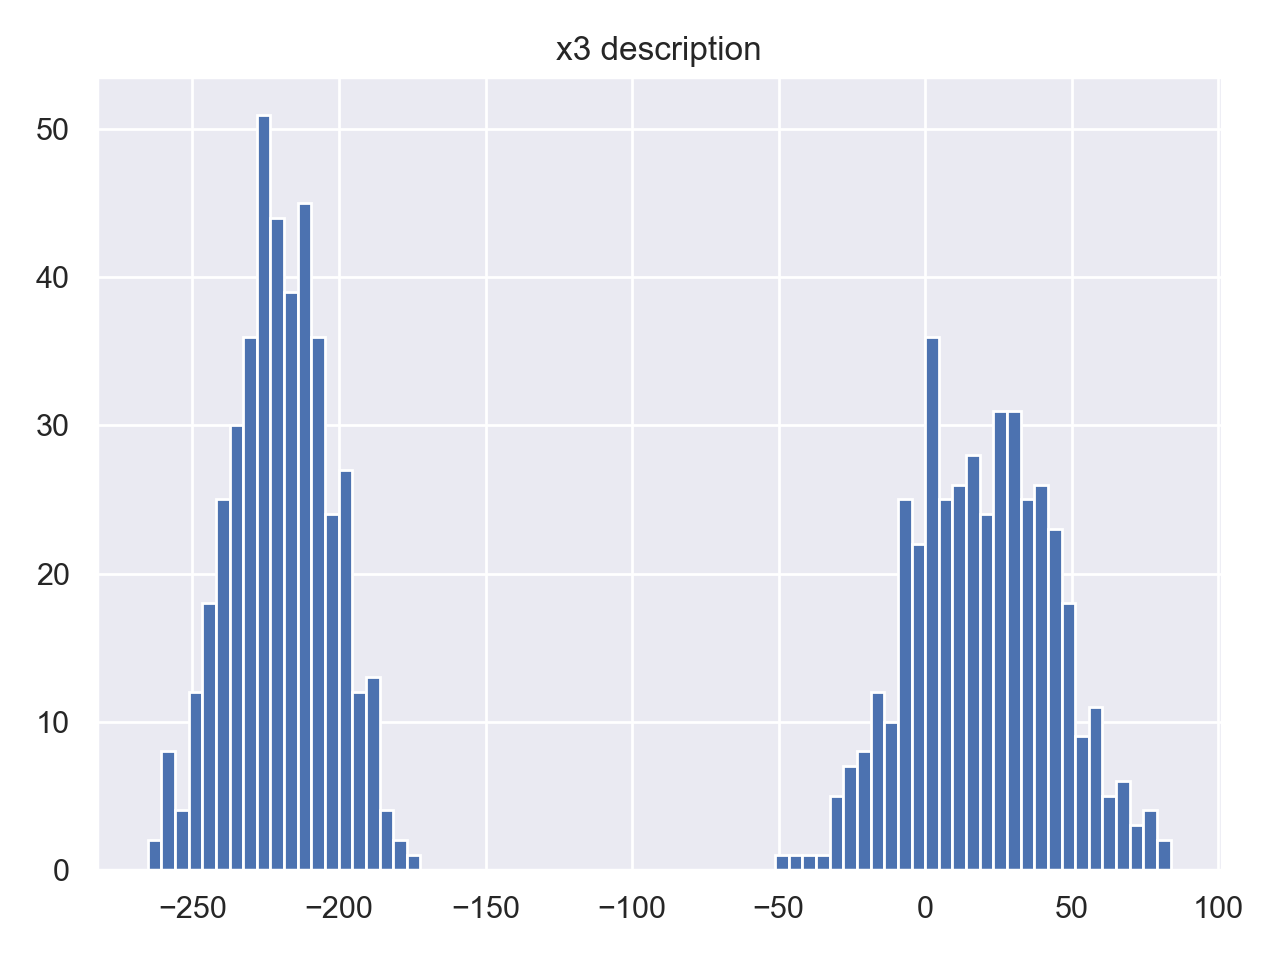

In [30]:
summarystats(data=df[df['y']==0], var='x3', titleplot='x3 description', n_bins=75)

[-227.92051113 -211.49881456 -211.67832279 -213.80042708 -158.83164991
 -236.0450865  -204.31296253 -217.4668751  -218.54206017 -215.86972412
 -216.07199867 -282.94573605 -213.71281216 -255.82179637 -220.82266988
 -220.06283259 -229.72705906 -213.25607181 -223.93164645 -213.00530819
 -185.96918393 -216.54652169 -229.36718591 -211.28503321 -225.8587148
 -224.0910082  -241.54588236 -230.22557149 -218.56098623 -216.51002881
 -253.86943627 -229.84757945 -219.76316804 -168.34428333 -221.49270048
 -222.61216991 -223.77237621 -214.57327673 -222.88212739 -224.14910285
 -209.87024336 -217.9474969  -164.37575426 -218.45142687 -231.63685249
 -211.89195494 -216.152071   -201.083843   -212.2840164  -217.00297569
 -218.6247547  -214.82013696 -223.87907661 -218.83859278 -253.04007001
 -213.66646493 -218.68710837 -210.4496722            nan -195.53236606
 -221.55961058 -221.97306991 -218.98015285 -260.58915538 -218.12166894
 -216.39007773 -240.50120421 -217.92872544 -223.38969166 -243.90580866
 -245.7

<IPython.core.display.Javascript object>


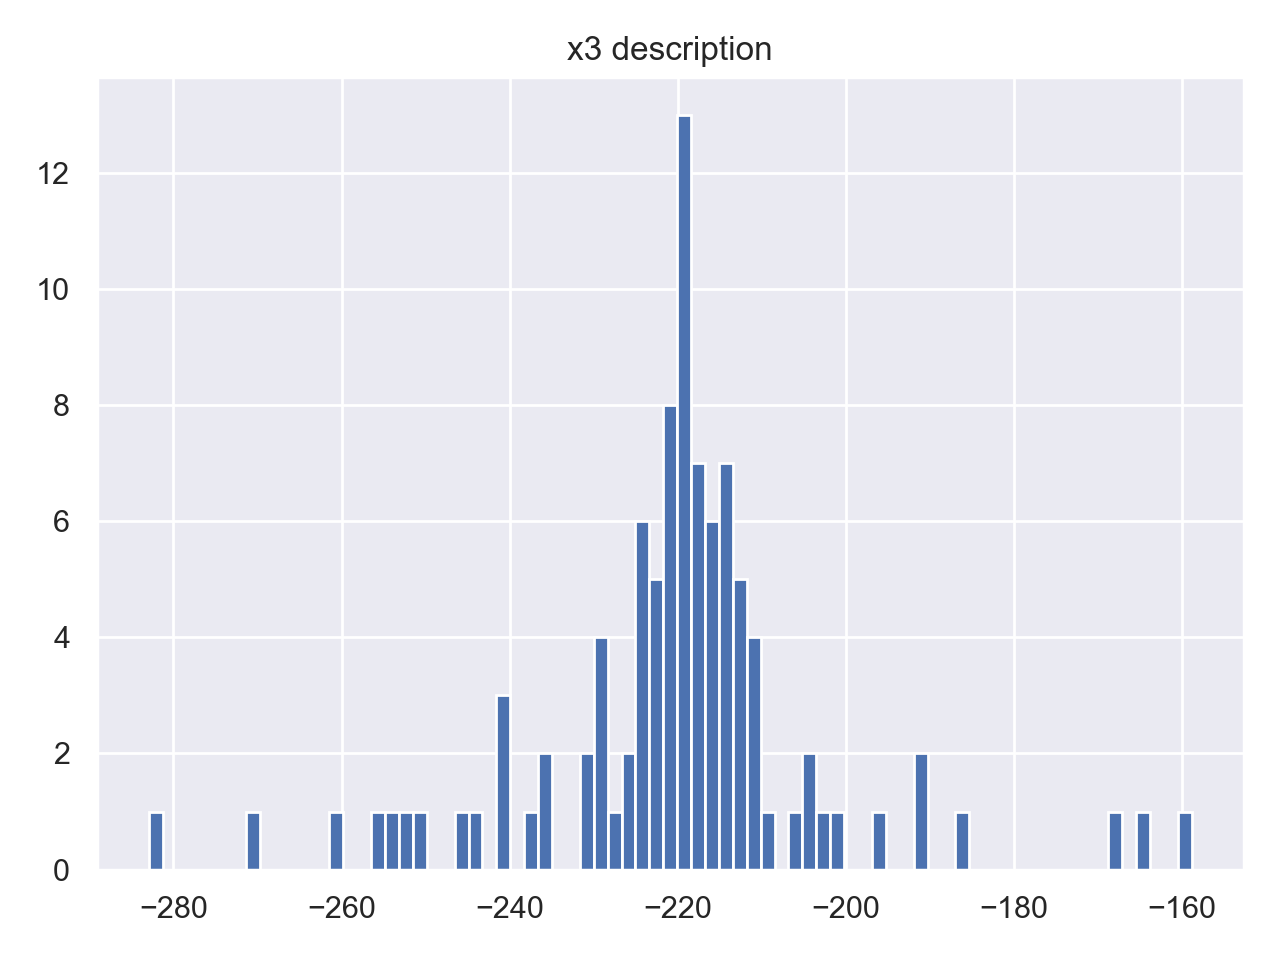

In [31]:
summarystats(data=df[df['y']==1], var='x3', titleplot='x3 description', n_bins=75)

[  308.92705793            nan  -281.11072519  -329.42499564
   473.8750438    553.45790077   763.18501107   998.07555434
   100.60530505  -741.08434427  -720.6950627   -351.54872802
   129.95707238   810.4102445   3381.00508059  1034.71200698
   268.02037459  -728.58910117  1598.45714804    42.30273973
   248.40501641  -334.39374593  -129.95983698  -473.4639361
   150.82470043   236.37711421  -290.0021066    550.06287094
  -180.34146388  -300.02806783  -156.33911069  1589.2541127
   971.16953738   671.26214358  -651.72092566  -642.68924296
   686.23240776  -304.02406243  -123.59971955  -325.716604
  1842.67653844  -545.49147368   683.648618    1042.64456625
  -307.57101517   -54.23895372  -518.22117325  -218.98513527
   261.63410614   646.84738425  -389.90633161   -65.67651688
  -508.65995853  1078.53820033   411.95809749  1108.86793873
 -1338.24259815   123.91123886  -368.71781914  -330.8854671
   147.87237663   -38.93283379   237.60273583  -107.14313144
   -24.36801466   130.9720520

<IPython.core.display.Javascript object>


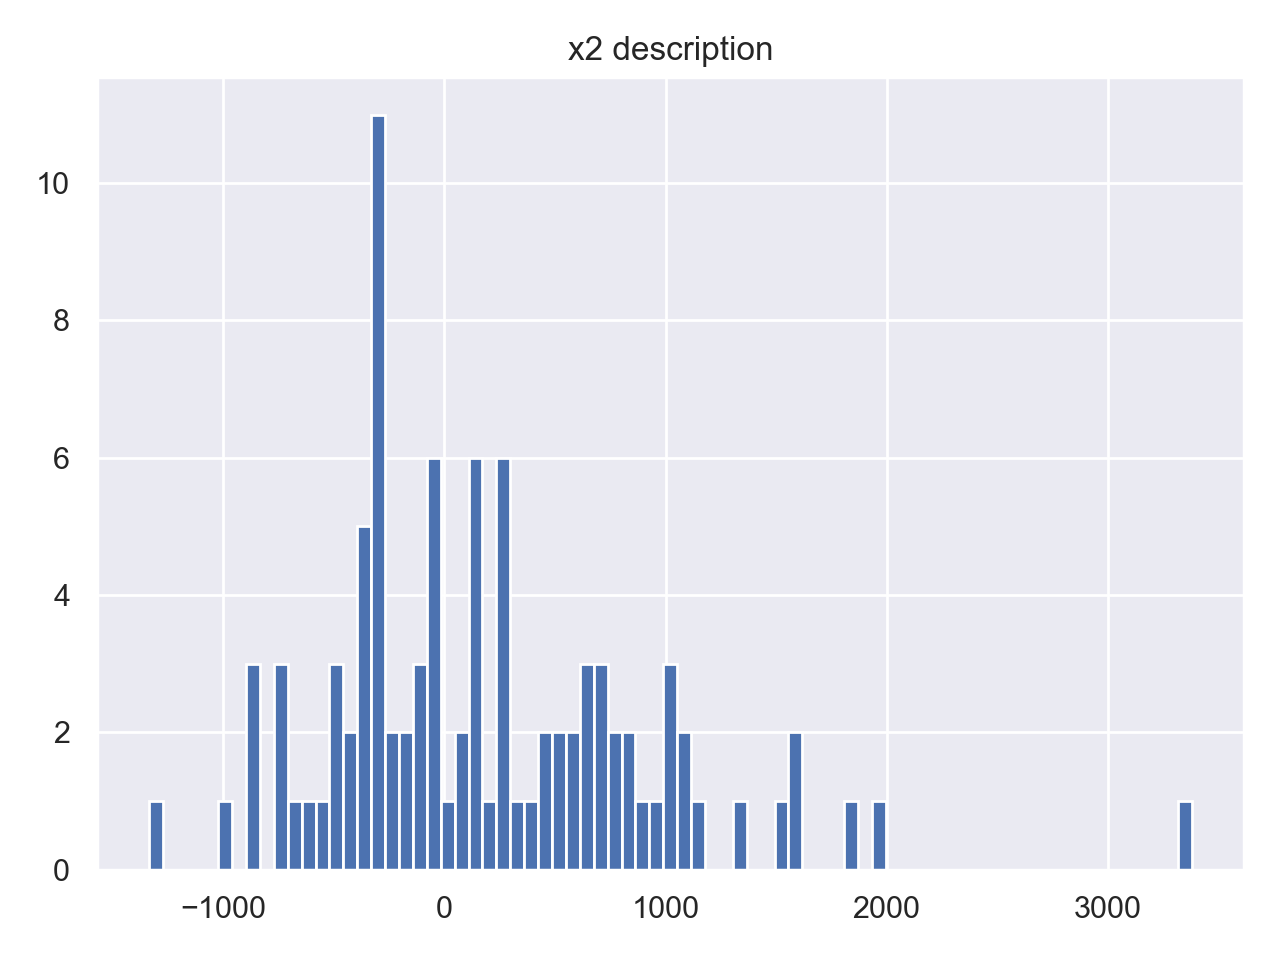

In [32]:
summarystats(data=df[df['y']==1], var='x2', titleplot='x2 description', n_bins=75)

[-15.1195556   -9.47816979 110.00005668 102.31637735  -6.58593498
  -3.25912957 -19.87275365  -6.18438648 140.87987933 104.59046971
  91.14454868 -10.56023896  81.70422254 -21.89810412 111.71078485
 123.39739751 119.09812623  -3.15666144 119.15217493  79.4487683
  -0.28346811 107.66980929 120.04427     97.71924533 101.48959676
  95.25379623 -15.09093316 -17.61795846 113.98316486 -14.60531082
 -16.9173752  104.33421402 109.98845497 -13.0050763    1.1690937
 128.10732494  98.33300795  85.45642112  -6.95886515 105.58586356
 104.27314589  99.79268662  -5.64045387 113.9910482   -8.75350497
  93.63480053 -10.41179492 -11.09639392  99.27070752  99.64427011
  94.7240689   99.43908875 109.9307492   -9.52162945 -23.95633835
 111.32474089 100.06426184  -3.23106707 123.06895142 -13.01307147
  74.03310998 118.92725101  96.1113548  -16.78329076 118.32558655
 104.78196315  -0.64114345 104.89939094 107.84358288 -18.45670509
 -10.78011833  -5.19580437 110.42195334 125.97799766  95.26896975
 123.1422911

<IPython.core.display.Javascript object>


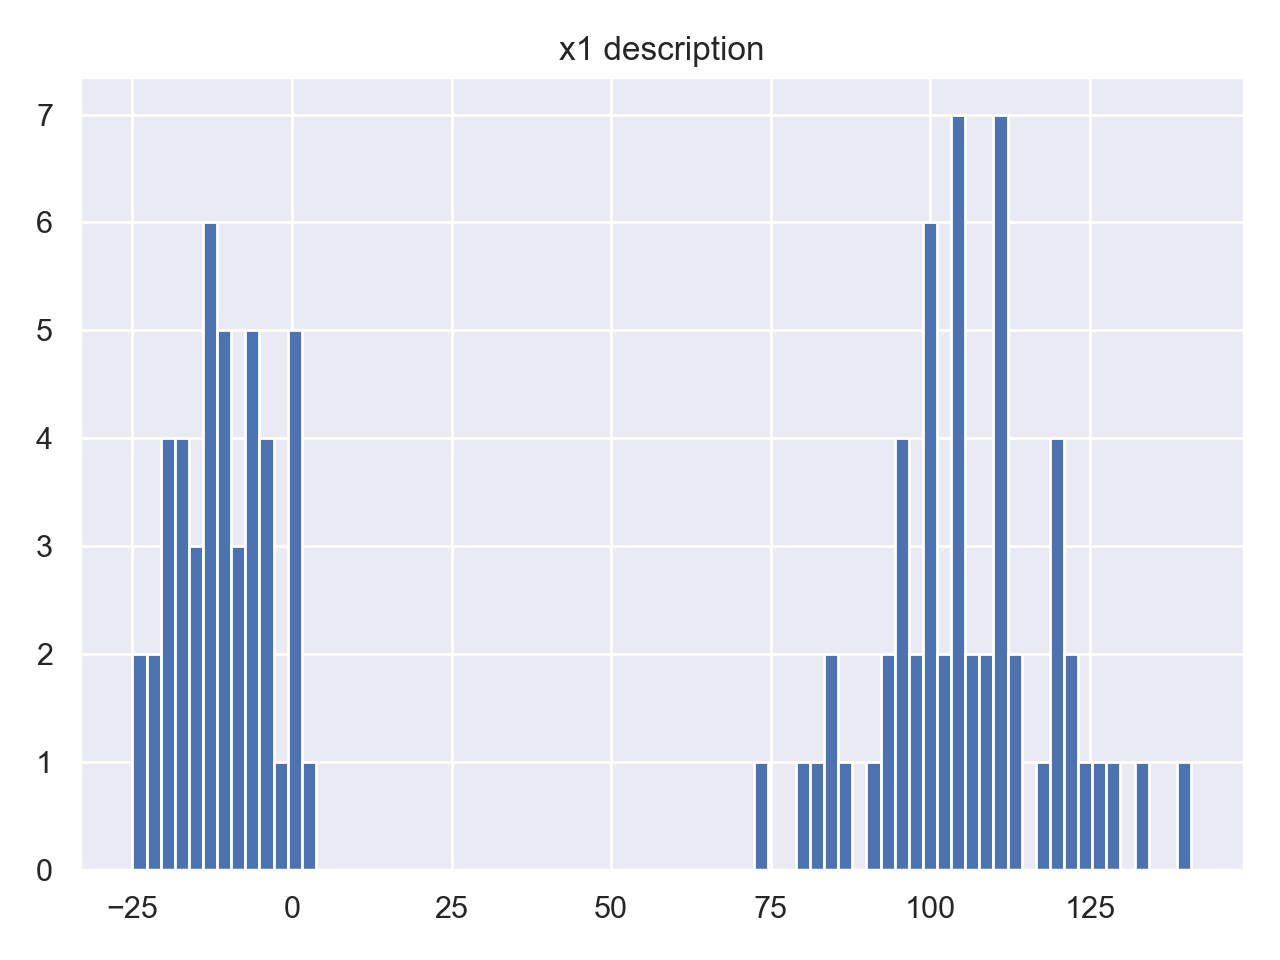

In [33]:
summarystats(data=df[df['y']==1], var='x1', titleplot='x1 description', n_bins=75)

[ 1.48723046e+01  3.63852923e+01 -3.74470001e+02 -3.58413149e+02
  6.26002959e+01  1.85367139e+01  1.64432455e+01  2.88912453e+01
 -2.90759194e+02 -3.11458800e+02 -3.38176882e+02 -2.81048033e+01
 -3.54380806e+02 -4.15999934e-03 -3.17085096e+02 -2.68355170e+02
  5.03776728e+01  4.59898488e+01 -3.14007568e+02 -3.51067649e+02
  6.00573066e+01 -3.24320925e+02 -3.09706222e+02 -3.52099980e+02
 -3.14516899e+02 -3.41744320e+02  1.84570721e+01  1.61809587e+01
 -3.73960045e+02  2.29971794e+01  4.62380007e+00 -3.34299201e+02
 -3.47345823e+02  6.10749975e+01  4.16104774e+01 -2.91317794e+02
 -3.69871049e+02 -3.52997622e+02  3.05663652e+01 -3.46786825e+02
 -3.45825886e+02 -3.45415954e+02  6.62274530e+01 -2.84636472e+02
  9.83929159e+00 -3.65540422e+02  2.77354262e+01  4.63191554e+01
 -3.51123870e+02 -3.15605876e+02 -3.54294051e+02             nan
 -2.92989358e+02  2.57063926e+01 -3.93325142e+00 -3.49871804e+02
 -3.65746404e+02  4.66981179e+01 -3.13613046e+02  4.95744523e+01
 -3.94163918e+02 -3.33027

<IPython.core.display.Javascript object>


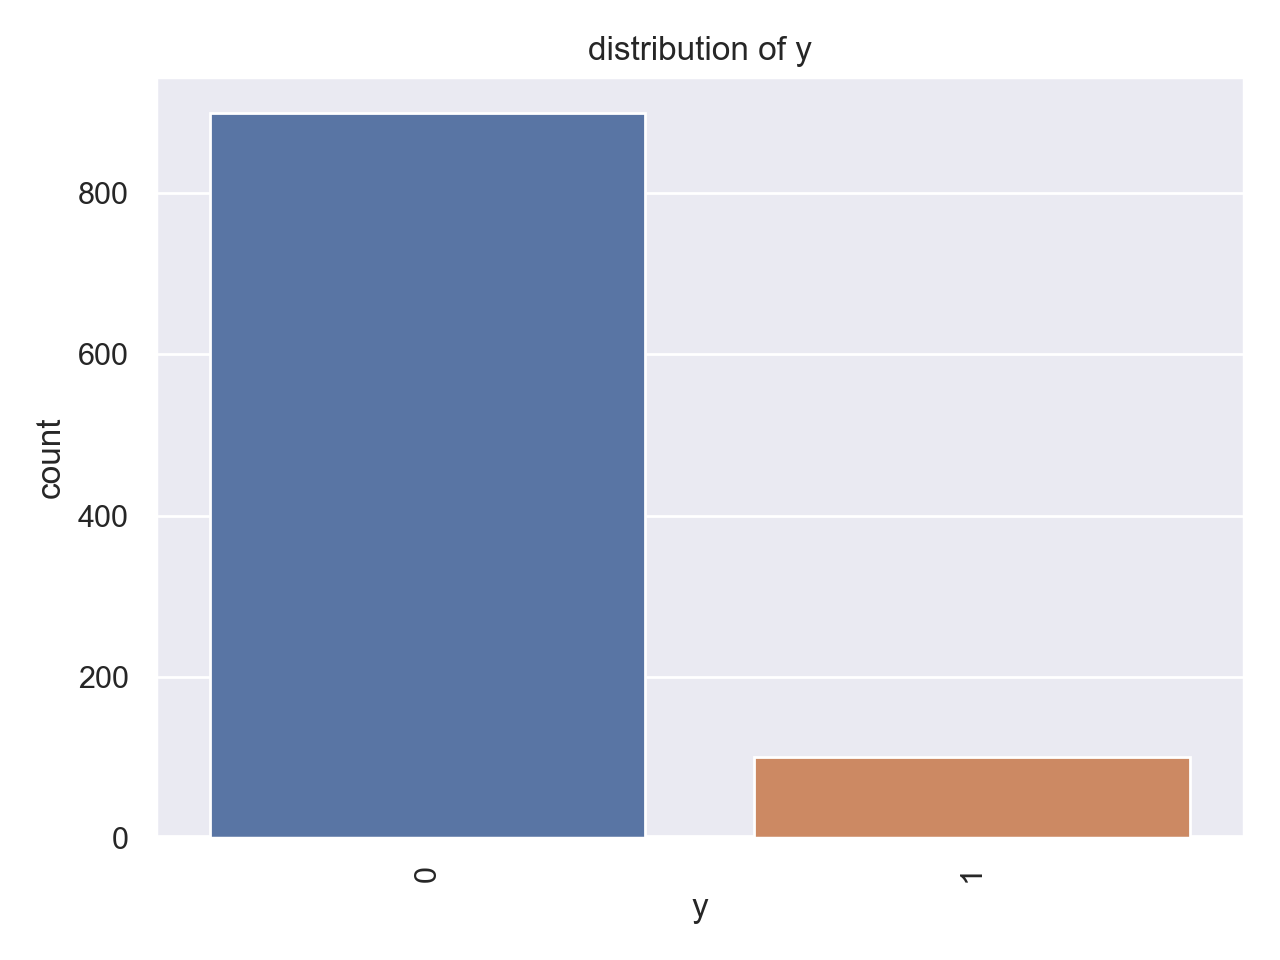

In [34]:
summarystats(data=df[df['y']==1], var='x0', titleplot='x0 description', n_bins=75)

<IPython.core.display.Javascript object>


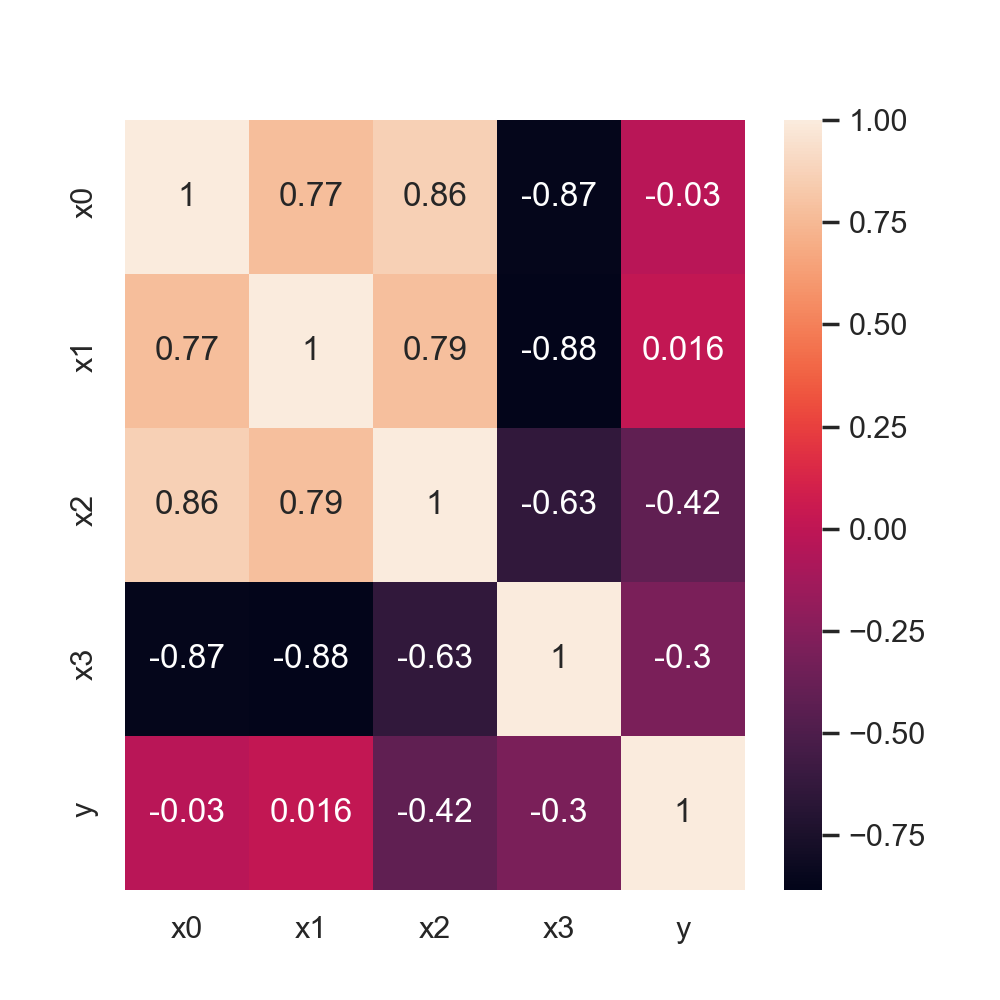

In [29]:
corrmap(data=df,figx=5, figy=5)

### Feature Engineering

In [39]:
df['x0_upper'] = np.where(df['x0']>0,1,0)
df['x0_lower'] = np.where(df['x0']<0,1,0)
df['x3_upper'] = np.where(df['x3']>-50,1,0)
df['x3_lower'] = np.where(df['x3']<-50,1,0)

In [40]:
# save engineered features into a list
feat_eng = ['x0_upper','x0_lower','x3_upper','x3_lower']
feature_dict['feat_eng'] = feat_eng

#### Evaluate features

In [41]:
binary_means(df,'feat_eng','y')

x0_upper
y
0    0.419355
1    0.386139
Name: x0_upper, dtype: float64

x0_lower
y
0    0.528365
1    0.594059
Name: x0_lower, dtype: float64

x3_upper
y
0    0.47386
1    0.00000
Name: x3_upper, dtype: float64

x3_lower
y
0    0.481646
1    0.970297
Name: x3_lower, dtype: float64



### Modeling and Evaluation

#### Principal Components Analysis

In [42]:
# def pca(dataframe, label):
#     ''' Principal Components Analysis to plot fraction of total variance explained by components'''

#     #initialize PCA
#     pca = PCA()

#     #fit PCA to training data
#     pca_data = pca.fit(dataframe.drop(label, axis = 1))

#     #get num of components
#     nc = pca.components_.shape[0]

#     #generate k values
#     ks = np.linspace(1,nc,num=nc)

#     #initialize a list to hold cumulate explained variance ratios
#     evrs = []
#     ev = 0 #cumulative explained variance

#     #loop over explained variance ratios for each component of the data
#     for evr in pca.explained_variance_ratio_:
#         #add to cumulative explained variance
#         ev += evr
#         #add the current cumulatove explained variance to the list
#         evrs.append(ev)


#     n = int(ks[-1])

#     #plot the results.
#     fig = plt.figure(figsize = (10,5))
#     plt.plot(ks[:n],evrs[:n],linewidth=2.5)
#     plt.title(f'Fraction of Total Variance for first {n} Principal Components',fontsize = 16)
#     plt.xlabel('k-th Principal Component',fontsize = 12)    
#     plt.ylabel('Fraction of Total Variance',fontsize = 12)
#     plt.show()

In [43]:
df_pca = df[feat_eng + float_vars]

In [46]:
#pca(dataframe=df_pca, label='y')

In [72]:
# # Show projection of training data in 2D using PCA

# def pcaProjection(dataframe, label):
#     ''' Project training data in 2D using PCA with 2 components'''
#     #initialize PCA with two principal components
#     pca = PCA(n_components=2)
#     #perform PCA on the traing data 
#     pca_data = pca.fit_transform(dataframe.drop(label, axis = 1))
    
#     #create individual arrays for X and Y principal components
#     X = np.array([i[0] for i in pca_data])
#     Y = np.array([i[1] for i in pca_data])

#     df_labels = np.array(dataframe[label])

#     #split the dataframe by its labels
# #     one_indices = [True if df_labels[i] == 2.0 else False for i in range(len(df_labels))]
# #     two_indices = [True if df_labels[i] == 1.0 else False for i in range(len(df_labels))]
# #     three_indices = [True if df_labels[i] == 0.0 else False for i in range(len(df_labels))]
# #     four_indices = [True if df_labels[i] == -1.0 else False for i in range(len(df_labels))]
# #     five_indices = [True if df_labels[i] == -2.0 else False for i in range(len(df_labels))]

# #     X_one = X[one_indices]
# #     X_two = X[two_indices]
# #     X_three = X[three_indices]
# #     X_four = X[four_indices]
# #     X_five = X[five_indices]

# #     Y_one = Y[one_indices]
# #     Y_two = Y[two_indices]
# #     Y_three = Y[three_indices]
# #     Y_four = Y[four_indices]
# #     Y_five = Y[five_indices]


# #     fig = plt.figure(figsize = (7,7))
# #     ax = fig.add_subplot(1, 1, 1)
# #     plt.scatter(X_one,Y_one, c = 'blue',marker='.',s=15)
# #     plt.scatter(X_five,Y_five, c = 'red',marker='.',s=15)
# #     plt.scatter(X_four,Y_four, c = 'orange',marker='.',s=15)
# #     plt.scatter(X_two,Y_two, c = 'green',marker='.',s=15)
# #     plt.scatter(X_three,Y_three, c = 'yellow',marker='.',s=15)
# #     ax.set_facecolor('gray')
# #     axes = plt.gca()
# #     axes.set_xlim([min(X) - 10,max(X)+ 10])
# #     axes.set_ylim([min(Y) - 10,max(Y)+ 10])

#     plt.title('Training Data Projected to 2-D',fontsize = 16)
#     plt.xlabel('Principal Component 1',fontsize = 12)
#     plt.ylabel('Principal Component 2',fontsize = 12)
#     plt.show()

In [ ]:
#pcaProjection(dataframe=df_pca, label='label')

#### Evaluation metrics functions

In [64]:
# check percentage of null values among model features
def check_null_percent(data_for_modeling, X_cols):
    return((data_for_modeling[X_cols].isnull().sum().sort_values(ascending=False).head(10)/data_for_modeling.shape[0])*100)

# binary class label
def calc_results(y_true, y_pred, y_prob):
    ''' Calculate accuracy, F1-score, Recall, Precision, ROC-AUC '''
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    precision = average_precision_score(y_true, y_prob)
    rocauc = roc_auc_score(y_true, y_prob)
    print('accuracy:', round(accuracy,4))
    print('recall:', round(recall,4))    
    print('precision:', round(precision,4))
    print('f1_score:', round(f1,4))
    print('roc_auc:', round(rocauc,4))
    print('')
    
# multiple class label
def calc_results_multi(y_true, y_pred, y_prob):
    ''' Calculate accuracy, F1-score, Recall, Precision, ROC-AUC '''
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    rocauc = roc_auc_score(y_true, y_prob, average='weighted', multi_class='ovr')
    print('accuracy:', round(accuracy,4))
    print('f1_score:', round(f1,4))
    print('roc_auc:', round(rocauc,4))
    print('')

In [48]:
# Apply randomized search cross-validation for a given classifier
def model_pipeline(imputer, scaler, classifier, params, scoring_metric, X_train, y_train, X_test, y_test, multi=False):
    pipeline = Pipeline([('imputer', imputer),
                         ('scaler', scaler),
                         ('classifier', classifier)])
    print(pipeline)
    search = RandomizedSearchCV(pipeline, param_distributions=params, n_iter=100,
                                scoring=scoring_metric, cv=5, refit=True, verbose=1, n_jobs=-1)
    search.fit(X_train, y_train)

    if multi:
        print('training set')
        calc_results_multi(y_train, search.predict(X_train), search.predict_proba(X_train))

        print('test set')
        calc_results_multi(y_test, search.predict(X_test), search.predict_proba(X_test))
        
    else:
        print('training set')
        calc_results(y_train, search.predict(X_train), search.predict_proba(X_train)[:,1])

        print('test set')
        calc_results(y_test, search.predict(X_test), search.predict_proba(X_test)[:,1])        
    
    print('best parameters')
    print(pd.Series(search.best_params_))
    
    return(search)

In [49]:
def feat_importance(search, X_cols, model_type):
    ''' Show feature importance '''
    feat_importance = pd.DataFrame()
    if model_type == 'logistic':
        feat_importance = pd.DataFrame([search.best_estimator_['classifier'].coef_[0]], columns=X_cols).T
        feat_importance.columns = ['coef']
        feat_importance['abs_coef'] = np.abs(feat_importance['coef'])
        feat_importance.sort_values('abs_coef', ascending=False, inplace=True)
    elif model_type == 'tree':
        feat_importance = pd.DataFrame([search.best_estimator_['classifier'].feature_importances_], columns=X_cols).T
        feat_importance.columns = ['importance']
        feat_importance.sort_values('importance', ascending=False, inplace=True)
    return(feat_importance)

#### Split train and validation sets

In [55]:
y_col = 'y'
#data_for_modeling = df[float_vars+feat_eng]
data_for_modeling = df
data_for_modeling = data_for_modeling[(data_for_modeling[y_col].isnull()==False)]

In [ ]:
# temporal train and test
# df_train = data_for_modeling[data_for_modeling['date']<=datetime.date(yyyy,mm,dd)]
# df_dev = data_for_modeling[data_for_modeling['date']>datetime.date(yyyy,mm,dd)]

In [ ]:
# random split by dates
def ts_daily_train_dev_split(df, date_feature, test_size, random_state=None):
    
    """Time Series Cross Validator, avoids shuffling information within unique days.
    
    Given a dataframe containing time series with a time step shorter than 1 day and with a variable containing each
    unique date (day), returns 2 dataframes with train and test sets, where data belonging to every unique day can be in
    one of the test sets only.
    
    param df: original dataframe
    param date feature: datetime feature name to split by
    param test_size: test size relative to whole size [0, 1]
    param random_state: random state to replicate the split
    
    return df_train: dataframe with training set
    return df_dev: dataframe with development(dev) set
    """
    
    # Get the list of unique dates in df and create a pandas Series
    days_list = df[date_feature].unique()
    sampled_series = pd.Series(days_list)
    
    # Get train and dev dates(days)
    train, test = train_test_split(sampled_series, test_size=test_size, random_state=random_state)
    
    # Split dataframe
    df_train = df.loc[df[date_feature].isin(train)]
    df_test = df.loc[df[date_feature].isin(dev)]
    
    # Return data sets
    return df_train, df_test

In [ ]:
test_frac = 0.2
ts_daily_train_dev_split(df=data_for_modeling, date_feature='date', test_size=test_frac, random_state=None)

In [56]:
# random split general - not by dates
#stratify randomization by label and relevant features
test_frac = 0.2
df_train, df_test = train_test_split(data_for_modeling, test_size=test_frac, 
                               random_state=random_seed, stratify=data_for_modeling[[y_col]]) 

In [57]:
# check fraction by categories in the train set
print(df_train[y_col].value_counts(dropna=False))
print(df_train[y_col].value_counts(dropna=False)/len(df_train))

# check fraction by categories in the test set
print(df_test[y_col].value_counts(dropna=False))
print(df_test[y_col].value_counts(dropna=False)/len(df_test))

0    719
1     81
Name: y, dtype: int64
0    0.89875
1    0.10125
Name: y, dtype: float64
0    180
1     20
Name: y, dtype: int64
0    0.9
1    0.1
Name: y, dtype: float64


In [58]:
# create the X train and dev datasets
X_train = df_train.drop('y', axis=1)
X_test = df_test.drop('y', axis=1)

# create the target variable
y_train = df_train[y_col]
y_test = df_test[y_col]

#### Apply Boruta methods for feature selection

In [62]:
# remove unwanted features
X_cols = list(X_train.columns)
# for x in ['xxx', 'xxy', 'xxz']:
#     X_cols.remove(x)

# for x in X_cols:
#     if X_train[x].dtypes == 'object':
#         X_cols.remove(x)        

In [ ]:
# impute missing values and standardize values 
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
scaler = StandardScaler()

imputer.fit(df_train[X_cols])
Ximp = imputer.transform(df_train[X_cols])
scaler.fit(Ximp)
Xscaled = scaler.transform(Ximp)

In [ ]:
# instantiate random forest
forest = RandomForestRegressor(n_jobs = -1, max_depth = 5)

# fit boruta
boruta_selector = BorutaPy(forest, n_estimators = 'auto', random_state = 0)
boruta_selector.fit(np.array(Xscaled), np.array(df_train[y_col]))

In [ ]:
# select top x features following Boruta ranking
x = 10
boruta_ranking = boruta_selector.ranking_
for i, val in enumerate(boruta_ranking):
    if val <= x:
        print (val, X_cols[i])

In [ ]:
orig_X_cols = X_cols

In [ ]:
# store results
boruta_ranking = boruta_selector.ranking_
selected_features = np.array(X_cols)[boruta_ranking <= 2]
print(selected_features)

## Models

In [59]:
# assign scoring metric based on class imbalance in label
# scoring_metric = 'roc_auc'
#scoring_metric = 'average_precision'
scoring_metric = 'f1_weighted'

### Logistic regression

In [65]:
# using no feature selection techniques
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
scaler = StandardScaler()
classifier = LogisticRegression(random_state=random_seed, class_weight='balanced')
params = {'classifier__C': uniform(0.01, 1), 'classifier__penalty': ['l1','l2','elasticnet']}
# scoring_metric = 'roc_auc'
# scoring_metric = 'average_precision'
lr = model_pipeline(imputer, scaler, classifier, params, scoring_metric, df_train[X_cols], df_train[y_col],
                     df_test[X_cols], df_test[y_col])

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('classifier',
                 LogisticRegression(class_weight='balanced',
                                    random_state=224))])
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    1.4s


training set
accuracy: 0.965
recall: 0.9753
precision: 0.9419
f1_score: 0.8495
roc_auc: 0.995

test set
accuracy: 0.95
recall: 0.95
precision: 0.9409
f1_score: 0.7917
roc_auc: 0.9764

best parameters
classifier__C          0.0288662
classifier__penalty           l2
dtype: object


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    5.2s finished


In [66]:
# Assess feature importance
feat_importance(lr, X_cols, 'logistic')

,coef,abs_coef
x2,-1.503446,1.503446
x3_upper,-0.852187,0.852187
x3_lower,0.769744,0.769744
x3,-0.684680,0.684680
x1,-0.458457,0.458457
x0,-0.101627,0.101627
x0_upper,0.058442,0.058442
x0_lower,0.026930,0.026930


<IPython.core.display.Javascript object>


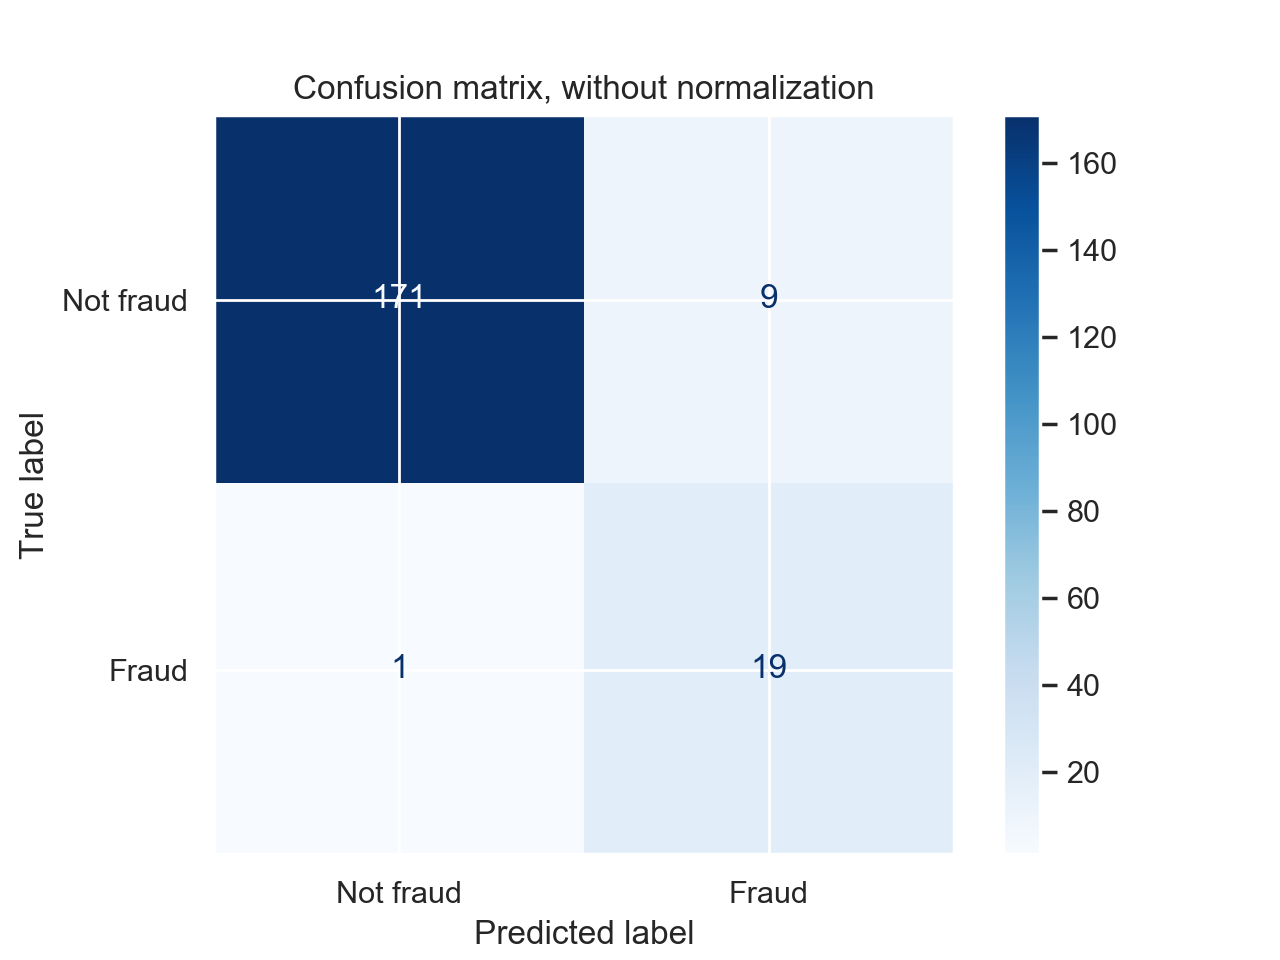

<IPython.core.display.Javascript object>


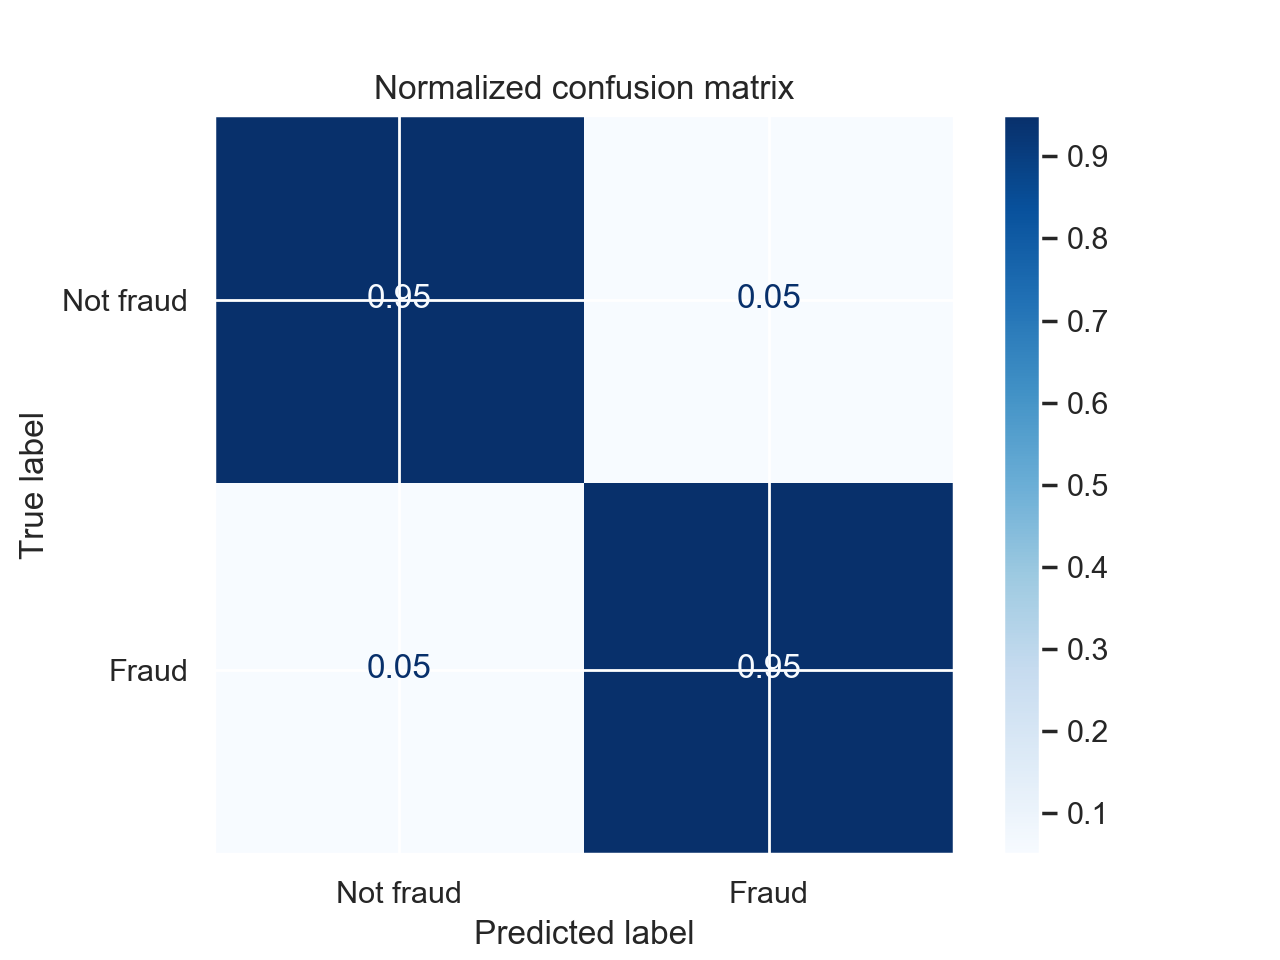

In [68]:
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]

for title, normalize in titles_options:
    disp = plot_confusion_matrix(lr, df_test[X_cols], df_test[y_col],
                                 display_labels=["Not fraud", "Fraud"],
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    
    disp.ax_.set_title(title)
plt.show()

In [ ]:
# classification report
# get predictions on dev
test_predictions = lr.predict(df_test[X_cols])
# get predicted probabilities for each class on dev
test_probs = lr.predict_proba(df_test[X_cols])

target_names = ["Category 1", "Category 2"]
print(classification_report(df_test[y_col], test_predictions,target_names = target_names))

In [ ]:
# using Boruta feature selection techniques
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
scaler = StandardScaler()
classifier = LogisticRegression(random_state=random_seed, class_weight='balanced')
params = {'classifier__C': uniform(0.01, 1), 'classifier__penalty': ['l1','l2','elasticnet']}
# scoring_metric = 'roc_auc'
# scoring_metric = 'average_precision'
lr_boruta = model_pipeline(imputer, scaler, classifier, params, scoring_metric, df_train[selected_features], df_train[y_col],
                     df_test[selected_features], df_test[y_col])

In [ ]:
# Assess feature importance
feat_importance(lr_boruta, selected_features, 'logistic')

In [ ]:
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]

for title, normalize in titles_options:
    disp = plot_confusion_matrix(lr_boruta, df_test[selected_features], df_test[y_col],
                                 display_labels=["Decided", "Undecided"],
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    
    disp.ax_.set_title(title)
plt.show()

In [ ]:
# classification report
# get predictions on test
test_predictions = lr_boruta.predict(df_test[selected_features])
# get predicted probabilities for each class on dev
test_probs = lr_boruta.predict_proba(df_test[selected_features])

target_names = ["Category 1", "Category 2"]
print(classification_report(df_test[y_col], test_predictions, target_names = target_names))

### Random Forest

In [ ]:
# Random Forest
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
scaler = StandardScaler()
classifier = RFC(random_state=random_seed, class_weight='balanced', bootstrap=True)
params = {'classifier__max_leaf_nodes': randint(30,120), 'classifier__max_depth': randint(30, 100),
           'classifier__min_samples_leaf': randint(15,50), 'classifier__criterion': ['gini','entropy'],
           'classifier__n_estimators': randint(30,150)}
#scoring_metric = 'average_precision'
rf = model_pipeline(imputer, scaler, classifier, params, scoring_metric, 
                         df_train[selected_features], df_train[y_col], df_test[selected_features], df_test[y_col])

In [ ]:
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]

for title, normalize in titles_options:
    disp = plot_confusion_matrix(rf, df_test[selected_features], df_test[y_col],
                                 display_labels=["Categrory 1", "Categrory 2"],
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    
    disp.ax_.set_title(title)
plt.show()

In [ ]:
# Assess feature importance
feat_importance(rf, selected_features, 'tree')

### Gradient Boosted Classifier

In [ ]:
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
scaler = StandardScaler()
classifier = GBC(learning_rate=0.1, max_features='sqrt', random_state=random_seed)
params = {'classifier__max_leaf_nodes': randint(30,120), 'classifier__max_depth': randint(30, 100),
           'classifier__min_samples_leaf': randint(15,50), 'classifier__criterion': ['friedman_mse',  'mae'],
           'classifier__n_estimators': randint(30,150), 
          'classifier__learning_rate': [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
         'classifier__loss':['deviance','exponential']} # default to subsample =1
#scoring_metric = 'roc_auc'
gbc = model_pipeline(imputer, scaler, classifier, params, scoring_metric, 
                     df_train[selected_features], df_train[y_col], df_test[selected_features], df_test[y_col])

In [ ]:
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]

for title, normalize in titles_options:
    disp = plot_confusion_matrix(gbc, df_test[selected_features], df_test[y_col],
                                 display_labels=["Categrory 1", "Categrory 2"],
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    
    disp.ax_.set_title(title)
plt.show()

In [ ]:
# Assess feature importance
feat_importance(gbc, selected_features, 'tree')

### Multi-Layer Perceptron (Neural Network)

In [ ]:
# MLPClassifier
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
scaler = StandardScaler()
classifier = MLPClassifier(random_state=random_seed)
params = {'classifier__hidden_layer_sizes': randint(3, 100), 
          'classifier__activation': ['identity','logistic','tanh','relu'],
          'classifier__alpha': [1e4,1e3,1e2], 
          'classifier__learning_rate': ['constant', 'invscaling','adaptive'], 
          'classifier__max_iter': randint(150,250), 
          'classifier__early_stopping': [True, False]}
#scoring_metric = 'roc_auc'
mlp = model_pipeline(imputer, scaler, classifier, params, scoring_metric, 
                    df_train[selected_features], df_train[y_col], df_test[selected_features], df_test[y_col])

In [ ]:
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]

for title, normalize in titles_options:
    disp = plot_confusion_matrix(mlp, df_test[selected_features], df_test[y_col],
                                 display_labels=["Categrory 1", "Categrory 2"],
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    
    disp.ax_.set_title(title)
plt.show()

### Predictions

In [ ]:
# impute missing values and standardize values 
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
scaler = StandardScaler()

imputer.fit(df[selected_features])
Ximp = imputer.transform(df[selected_features])
scaler.fit(Ximp)
Xscaled = scaler.transform(Ximp)

y = df[y_col]

def run_prob_cv(X, y, clf_class, **kwargs):
    kf = KFold(n_splits=5, shuffle=True)
    y_prob = np.zeros((len(y),2))
    
    # Iterate through folds
    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        
        # Initialize a classifier with key word arguments
        clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        # Predict probabilities, not classes
        y_prob[test_index] = clf.predict_proba(X_test[:])
    return y_prob, clf

In [ ]:
# Use 10 estimators so predictions are all multiples of 0.1
pred_prob = run_prob_cv(Xscaled,y,GBC,n_estimators=10)
preds = pred_prob[0][:,1]

In [ ]:
import warnings
warnings.filterwarnings('ignore')

is_churn = df[y_col] == 1

# Number of times a predicted probability is assigned to an observation
counts = pd.value_counts(preds)

# Calculate true probabilities
true_prob = {}
for prob in counts.index:
    true_prob[prob] = np.mean(is_churn[preds==prob])
    true_prob = pd.Series(true_prob)

# pandas-fu
counts = pd.concat([counts,true_prob],axis=1).reset_index()
counts.columns = ['pred_prob','count','true_prob']
counts

In [ ]:
# plot predicted probabilites verses true probabilities
fig, axs = plt.subplots(1, 1, sharey=True, tight_layout=True)
plt.style.use('seaborn-whitegrid')
rng = np.random.RandomState(0)
colors = rng.rand(len(counts))
sizes = 1000 * rng.rand(100)

plt.scatter(counts['pred_prob'], counts['true_prob'], c=colors, s=sizes, 
            alpha=0.3,cmap='viridis')
plt.xlabel('predicted prob')
plt.ylabel('true prob')
plt.colorbar();  # show color scale